# 1. The simplest implementation of Flow Matching

We have a training dataset of samples from some target distribution $q$ over $\mathbb{R}$. 

To build a model capable of generating new samples from $q$, Flow Matching (FM) builds a probability path $(p_t)_{0 \leq t \leq 1}$ from a source Gaussian distribution $p_0=p$ to the data target distribution $p_1=q$. 

FM is an objective to train the velocity field neural network which is used to convert the source distribution $p_0$ into the target distribution $p_1$, along the probability path $p_t$. 

After this neural network is trained, we can generate new samples by drawing a sample from the source distribution $X_0 \sim p$ and solving the ODE determined by the velocity field. 

We do this in two steps: 

1. we design the probability path $p_t$ interpolating between $p$ and $q$.

Let the source distribution be $p:=p_0=\mathcal{N}(x|0, I)$. We construct the probability path $p_t$ known as the conditional optimal-transport or linear path:

$$
p_t(x) = \int p_{t|1}(x|x_1) q(x_1) \, dx_1
$$

where $p_{t|1}(x|x_1)=\mathcal{N}(x|tx_1, (1-t^2)^2I)$.

Based on this probability path we define the random variable $X_t \sim p_t$ by drawing $X_0$ from $p$, drawing $X_1$ from $q$, and taking their linear combination:

$$
X_t = tX_1 + (1-t)X_0 \sim p_t
$$

2. we train a velocity field $u^\theta_t$.

To do this we could regress the neural network velocity field $u^\theta_t$ to a known target velocity field $u_t$. For this, we would use the Flow Matching Loss (FML):

$$
L_{FM}=E_{t, X_t}||u^\theta_t(X_t)-u_t(X_t)||^2
$$

where $t \sim U[0, 1]$ and $X_t \sim p_t$.

As stated in the article, FML is intractable. So, we simplify it by conditioning the loss on a single target $X_1=x_1$ picked at random from the training set. 

$$
X_t|_1 = t x_1 + (1 - t) X_0 \quad \sim \quad p_{t|1}(\cdot | x_1) = \mathcal{N}(\cdot | t x_1, (1 - t)^2 I)
$$

We then obtain the Conditional Flow Matching Loss (CFM).

$$
\mathcal{L}_{\text{CFM}}(\theta) = \mathbb{E}_{t, X_t, X_1} \| u^\theta_t(X_t) - u_t(X_t | X_1) \|^2
$$

$\text{where} \quad t \sim U[0,1], \quad X_0 \sim p, \quad X_1 \sim q$.

One important contribution given by the article was to show that FML and CFM provide the same gradients to learn $u^\theta_t$, that is $\nabla_\theta L_{FM}(\theta)=\nabla_\theta L_{CFM}(\theta)$.

Solving $\frac{d}{dt}X_{t|1} = u_t(X_{t|1}|X_1)$ and pluging the result into CFM, we have:

$$
\mathcal{L}^{\text{OT,Gauss}}_{\text{CFM}}(\theta) = \mathbb{E}_{t, X_0, X_1} \| u^\theta_t(X_t) - (X_1-X_0) \|^2
$$

In [1]:
import torch
from torch import nn,Tensor
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import make_moons

In [116]:
# flow visualization

def visualize_flow_sampling(flow, n_samples=300, n_steps=8):
    # Generate initial samples
    x = torch.randn(n_samples, 2)
    
    # Create subplots
    fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
    time_steps = torch.linspace(0, 1.0, n_steps + 1)
    
    # Plot initial samples
    axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[0].set_title(f't={time_steps[0]:.2f}')
    axes[0].set_xlim(-3.0, 3.0)
    axes[0].set_ylim(-3.0, 3.0)
    
    # Perform steps and plot samples at each step
    for i in range(n_steps):
        x = flow.step(x, time_steps[i], time_steps[i + 1])
        axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
        axes[i + 1].set_title(f't={time_steps[i + 1]:.2f}')
    
    plt.tight_layout()
    plt.show()
    

class SimpleNN(nn.Module):
    def __init__(self, dim:int = 2, h:int=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim+1, h), 
            nn.ELU(),
            nn.Linear(h,h), 
            nn.ELU(),
            nn.Linear(h,h), 
            nn.ELU(),
            nn.Linear(h,dim)
        )
        
    def forward(self, x_t:Tensor, t:Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end:Tensor) -> Tensor:
        t_start = t_start.view(1,1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end-t_start)/2,
                                              t_start + (t_end-t_start)/2)    
        
class UNetMNIST(nn.Module):
    def __init__(self, in_channels: int = 1, base_channels: int = 64):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels + 1, base_channels, kernel_size=3, padding=1),
            nn.ELU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU(),
        )
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, padding=1),
            nn.ELU(),
        )
        # Decoder
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU(),
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels, 1, kernel_size=3, padding=1),
        )

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Expand time tensor to match spatial dimensions
        b, c, h, w = x_t.shape
        t_expanded = t.view(b, 1, 1, 1).expand(-1, 1, h, w)

        # Concatenate time as an additional channel
        x = torch.cat((x_t, t_expanded), dim=1)  # Shape: [B, C+1, H, W]

        # Pass through the network
        enc1 = self.enc1(x)  # Adjust self.enc1 input channels if necessary
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        bottleneck = self.bottleneck(F.max_pool2d(enc2, 2))
        dec2 = self.dec2(F.interpolate(bottleneck, scale_factor=2, mode='bilinear', align_corners=False))
        dec1 = self.dec1(F.interpolate(torch.cat((dec2, enc2), dim=1), scale_factor=2, mode='bilinear', align_corners=False))

        return dec1

    def step(self, x_t: torch.Tensor, t_start: torch.Tensor, t_end: torch.Tensor) -> torch.Tensor:
        t_start = t_start.view(-1, 1, 1, 1).expand(x_t.shape[0], 1, x_t.shape[2], x_t.shape[3])
        return x_t + (t_end - t_start) * self(
            x_t + self(x_t, t_start) * (t_end - t_start) / 2,
            t_start + (t_end - t_start) / 2
        )  

In [3]:
# Simplest Flow Matching

class SimplestFM:
    
    def x_t(self, x_0: Tensor, x_1: Tensor, t) -> Tensor:
        return (1-t)*x_0+t*x_1
    
    def v_target(self, x_0:Tensor, x_1:Tensor) -> Tensor:
        return x_1-x_0

In [58]:
#training
v_theta=SimpleNN()
simplest_FM = SimplestFM() 
optimizer=torch.optim.Adam(v_theta.parameters(), 1e-2)
loss_fn=nn.MSELoss()

for _ in range(5000):
    x_1 =Tensor(make_moons(256,noise=0.05)[0])
    x_0 =torch.randn_like(x_1)
    t =torch.rand(len(x_1), 1)
    
    x_t = simplest_FM.x_t(x_0, x_1, t)
    v_target=simplest_FM.v_target(x_0, x_1)
    
    optimizer.zero_grad()
    
    loss_fn(v_theta(x_t,t),v_target).backward()
    
    optimizer.step() 

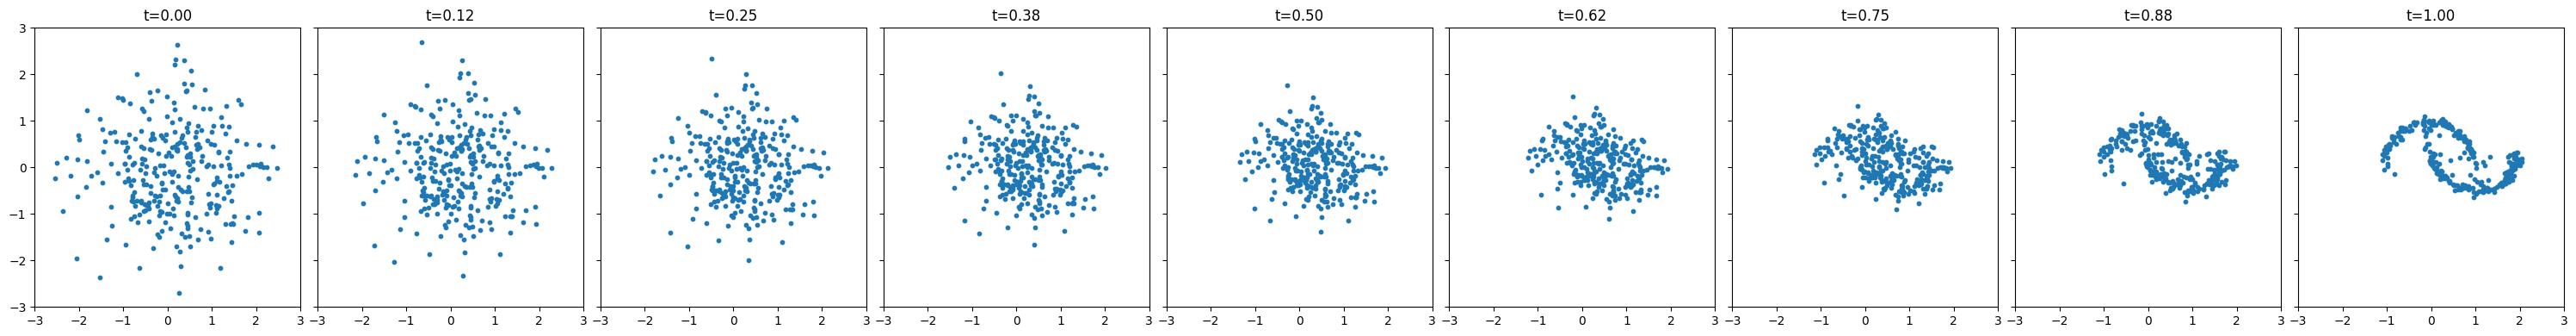

In [59]:
visualize_flow_sampling(v_theta)

# 2. Optimal Transport Flow Matching

## 2.1 make_moons dataset

In [4]:
# Optimal Transport Flow Matching   
class OTFM:   
    
    def phi_t(self, x_0, x_1, sigma_min, t) -> Tensor:
        return (1-(1-sigma_min)*t)*x_0+t*x_1
    
    def v_target(self, x_0:Tensor, x_1:Tensor, sigma_min:int) -> Tensor:
        return x_1 - (1-sigma_min)*x_0

In [10]:
# Optimal Transport conditional VFs

#training
v_theta=SimpleNN()
OTFM = OTFM() 
sigma_min = 0.001

optimizer=torch.optim.Adam(v_theta.parameters(), 1e-2)
loss_fn=nn.MSELoss()

for _ in range(5000):
    x_1 =Tensor(make_moons(256,noise=0.05)[0])
    x_0 =torch.randn_like(x_1)
    t =torch.rand(len(x_1), 1)

    v_t = OTFM.v_target(x_0, x_1, sigma_min)
    phi_t = OTFM.phi_t(x_0, x_1, sigma_min, t)
    
    optimizer.zero_grad()
    
    loss_fn(v_theta(phi_t,t),v_t).backward()
    
    optimizer.step() 

NameError: name 'SimpleNN' is not defined

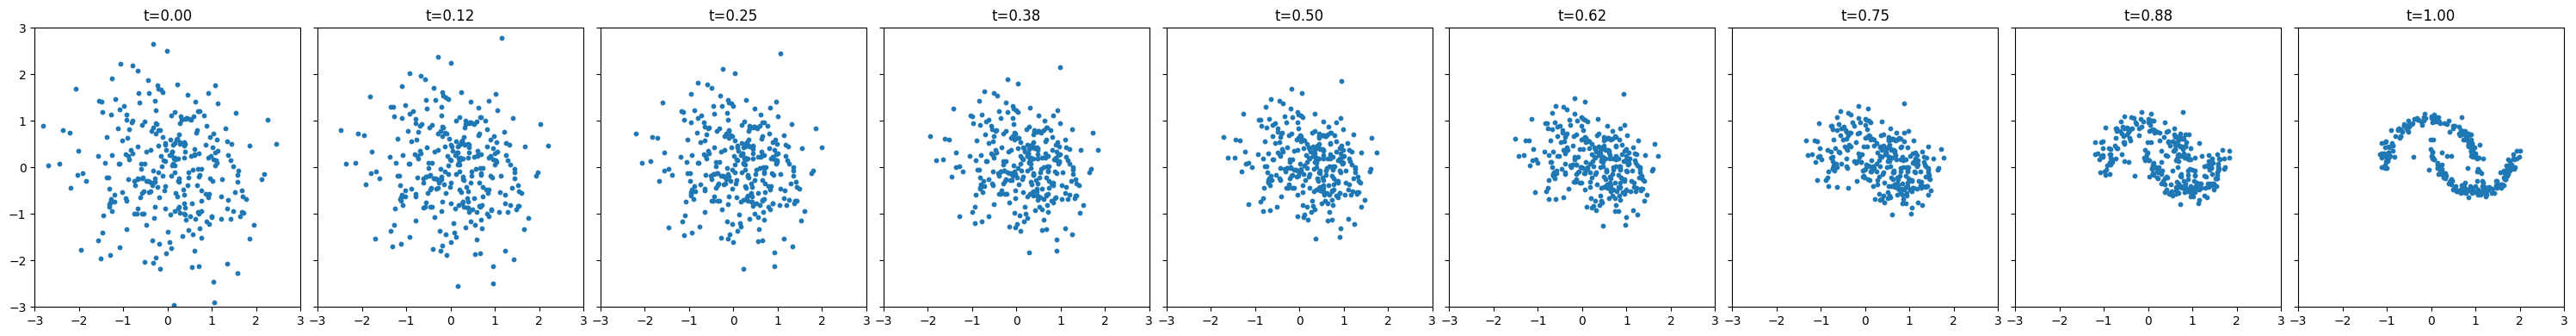

In [50]:
visualize_flow_sampling(v_theta)

## 2.2 MNIST dataset

Results at https://colab.research.google.com/drive/14nx5XWyYRCsFdDz3WUiVFgkq9WHRJUN5?usp=sharing

In [79]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [80]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data_mnist', train=True, download=True, transform=transform)

# Get indexes where target equals certain targets
idx = torch.where((train_dataset.targets == 1) | (train_dataset.targets == 7) | (train_dataset.targets == 9))[0]

# Create proper subset with both images and targets
train_subset = Subset(train_dataset, idx)
train_subset_loader = DataLoader(train_subset, batch_size=16, shuffle=True)

In [81]:
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50
from typing import Optional, Tuple

In [92]:
class UNetMNIST(nn.Module):
    def __init__(self, in_channels: int = 1, base_channels: int = 64):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels + 1, base_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.ELU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU()
        )
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels * 4, base_channels * 4, kernel_size=3, padding=1),
            nn.ELU()
        )
        # Decoder
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels * 6, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU()
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels * 3, base_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels, 1, kernel_size=3, padding=1)
        )

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Expand time tensor to match spatial dimensions
        b, c, h, w = x_t.shape
        t_expanded = t.expand(-1, 1, h, w)
        
        # Concatenate time as an additional channel
        x = torch.cat((x_t, t_expanded), dim=1)

        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc2, 2))
        
        # Decoder with skip connections
        dec2 = self.dec2(torch.cat([F.interpolate(bottleneck, scale_factor=2, mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=False), enc1], dim=1))
        
        return dec1

    def step(self, x_t: torch.Tensor, t_start: torch.Tensor, t_end: torch.Tensor) -> torch.Tensor:
        dt = t_end - t_start
        v_mid = self(x_t + self(x_t, t_start) * dt / 2, t_start + dt / 2)
        return x_t + dt * v_mid



def train_one_epoch(model, otfm, dataloader, optimizer, sigma_min, device):
    model.train()
    total_loss = 0
    
    for batch, _ in dataloader:  
        batch = batch.to(device)
        
        # Generate random noise
        x_0 = torch.randn_like(batch).to(device)
  
        x_1 = batch
        
        # Sample random times
        t = torch.rand(len(batch), 1, 1, 1).to(device)
        

        v_t = otfm.v_target(x_0, x_1, sigma_min)
        phi_t = otfm.phi_t(x_0, x_1, sigma_min, t)
        
        optimizer.zero_grad()
        

        v_pred = model(phi_t, t)
        loss = F.mse_loss(v_pred, v_t)
        
     
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def visualize_mnist_flow(model, n_samples=10, n_steps=8, device='cuda'):
    """
    Visualize the flow from noise to MNIST-like images.
    
    Args:
        model: The trained UNet model
        n_samples: Number of images to generate
        n_steps: Number of intermediate steps to show
        device: Device to run the model on
    """

    model.eval()
    
    # Generate initial random noise
    x = torch.randn(n_samples, 1, 28, 28).to(device)
    
    # Create subplots
    fig, axes = plt.subplots(n_samples, n_steps + 1, figsize=(2*(n_steps + 1), 2*n_samples))
    time_steps = torch.linspace(0, 1.0, n_steps + 1)
    
    # Plot initial noise samples
    for j in range(n_samples):
        axes[j, 0].imshow(x[j, 0].cpu().detach(), cmap='gray')
        axes[j, 0].axis('off')
    axes[0, 0].set_title(f't={time_steps[0]:.2f}')
    
    # Perform steps and plot samples at each step
    with torch.no_grad():
        for i in range(n_steps):
            t_start = torch.tensor([time_steps[i]], device=device).view(1, 1, 1, 1).expand(n_samples, -1, -1, -1)
            t_end = torch.tensor([time_steps[i + 1]], device=device).view(1, 1, 1, 1).expand(n_samples, -1, -1, -1)
            
            x = model.step(x, t_start, t_end)
            
            # Plot each sample
            for j in range(n_samples):
                axes[j, i + 1].imshow(x[j, 0].cpu().detach(), cmap='gray')
                axes[j, i + 1].axis('off')
            axes[0, i + 1].set_title(f't={time_steps[i + 1]:.2f}')
    
    plt.tight_layout()
    plt.show()

In [128]:

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
v_theta = UNetMNIST(in_channels=1).to(device)
otfm = OTFM()
sigma_min = 0.001
optimizer = torch.optim.AdamW(v_theta.parameters(), lr=3e-4)

num_epochs = 10
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(v_theta, otfm, train_subset_loader, optimizer, sigma_min, device)
    print(f"Epoch {epoch+1}/{num_epochs}: Average Loss = {avg_loss:.6f}")

Epoch 1/10: Average Loss = 0.390659
Epoch 2/10: Average Loss = 0.277491
Epoch 3/10: Average Loss = 0.255686
Epoch 4/10: Average Loss = 0.249491
Epoch 5/10: Average Loss = 0.240347
Epoch 6/10: Average Loss = 0.236938
Epoch 7/10: Average Loss = 0.232451
Epoch 8/10: Average Loss = 0.235379
Epoch 9/10: Average Loss = 0.232289
Epoch 10/10: Average Loss = 0.230281


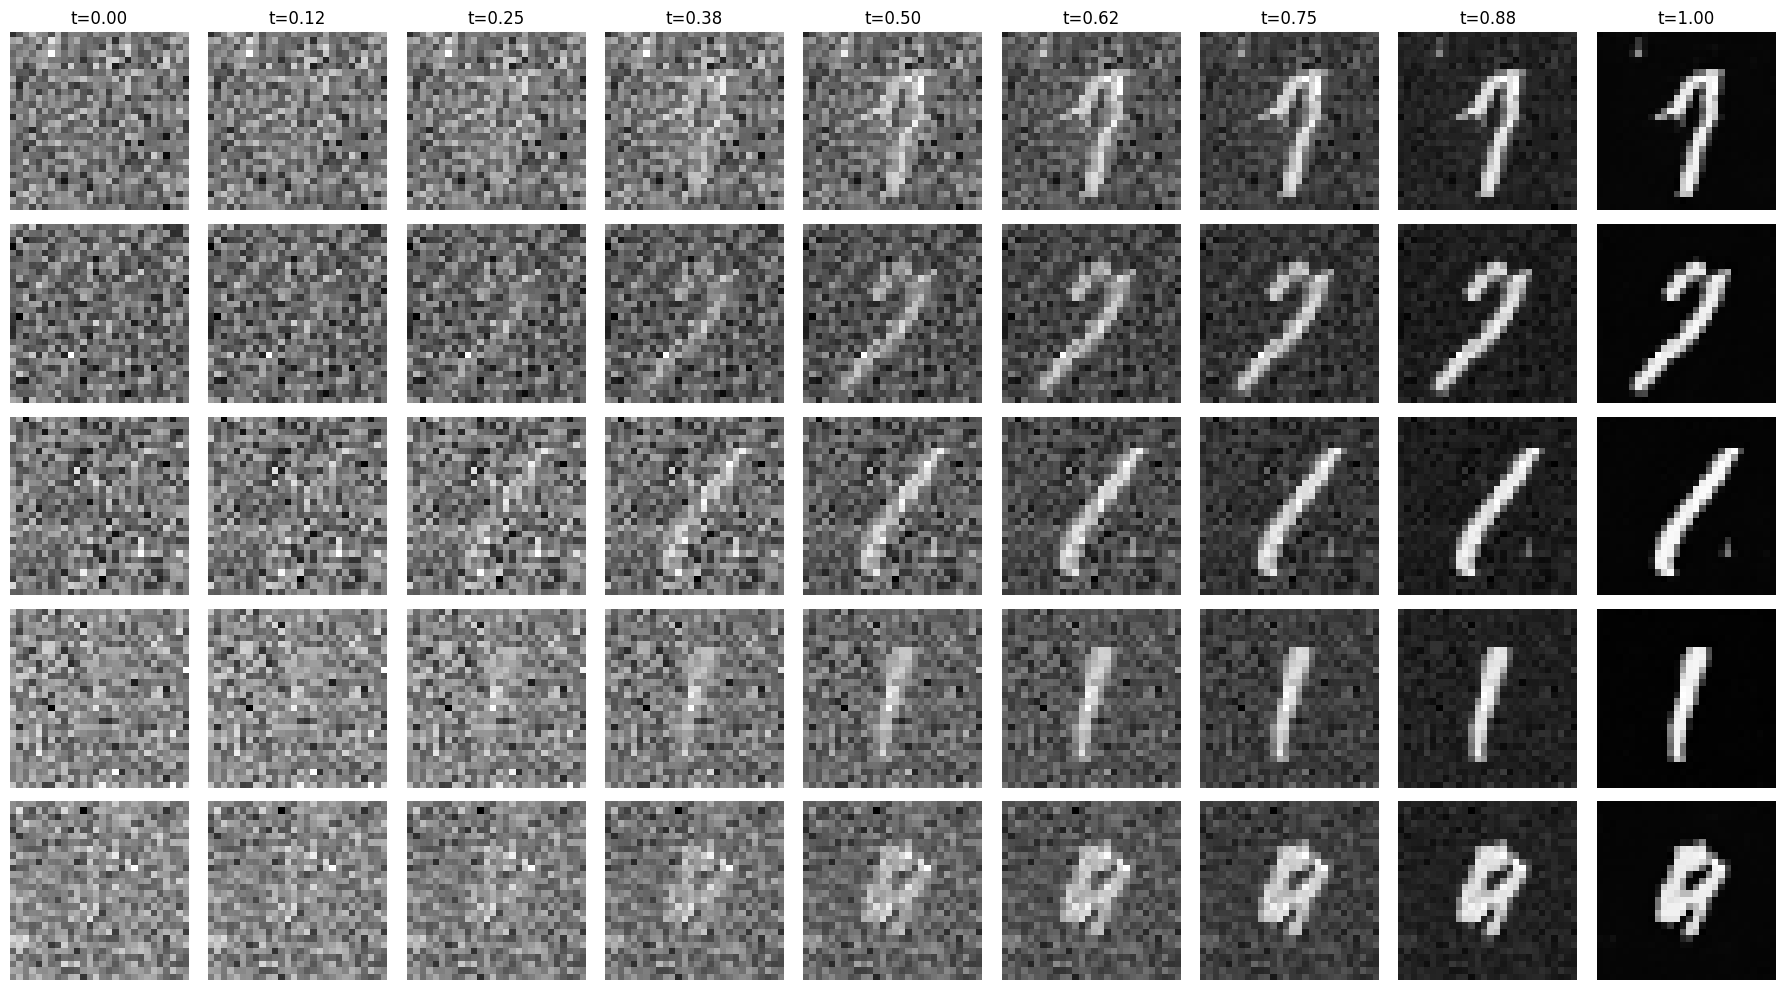

In [129]:
visualize_mnist_flow(v_theta, n_samples=5, n_steps=8, device=device)